# Let's Dive into CNNs
## Please read the following paragraph I copy-pasted from ChatGPT:
Welcome back to the exciting world of Convolutional Neural Networks (CNN), building on our previous question which focused on Multilayer Perceptrons (MLP)! As you already know, CNNs are a powerful tool for image and video processing applications. They are designed to recognize patterns and features in visual data, making them a popular choice in computer vision research. One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data, which preserves spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data. MLPs are limited in their ability to process images because they require that the input data be flattened into a one-dimensional vector, which can result in a loss of important spatial information. In contrast, CNNs are designed to handle multi-dimensional data such as images, preserving spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

In this assignment, we will be playing with the CIFAR-10 dataset to explore different CNN models. We will start by training an auto-encoder for CIFAR images. This auto-encoder will allow us to compare different models, including a Multilayer Perceptron (MLP) model, a CNN-MLP mixed model, and finally a CNN-only model. By comparing the performance of these models, we can gain a deeper understanding of the importance of CNN layers in image processing tasks.

Once we've completed our auto-encoder experiments, we will use the encoder from the best-performing model to train a Siamese network. Siamese networks are a type of neural network that can recognize similarity between two images, making them a popular choice for tasks such as image retrieval and face recognition. By training a Siamese network using the CIFAR-10 dataset, we can gain a better understanding of how CNNs can be used in more complex image recognition tasks.

Overall, this assignment will allow us to explore the many different applications of CNNs in image processing tasks. We'll have the opportunity to experiment with different architectures, compare their performance, and gain valuable insights into how CNNs can be used to solve real-world problems.

🫵Pro-tip: Utilize learnings from previous question to better solve problems in this question.

💭Trivia: Yes, I am allowed use ChatGPT!

## Part 0: Initialization
### Step zero: Import Libraries

In [1]:
# code here
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn

from tqdm import tqdm
from prettytable import PrettyTable

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Step one: Using a PyTorch Dataset
Load CIFAR-10 dataset from `torchvision.datasets`. Keep batch_size >= 16.

In [3]:
# code here
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

trainset = datasets.CIFAR10(
    root = 'data',
    train = True,                         
    transform = transform, 
    download = True,            
)
#TODO use datasets.MNIST
testset = datasets.CIFAR10(
    root = 'data', 
    train = False, 
    transform = transform
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                                    , shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64
                                                    , shuffle=True, num_workers=2)
print(len(trainloader), len(testloader))

782 157


torch.Size([64, 3, 32, 32])
torch.Size([64])


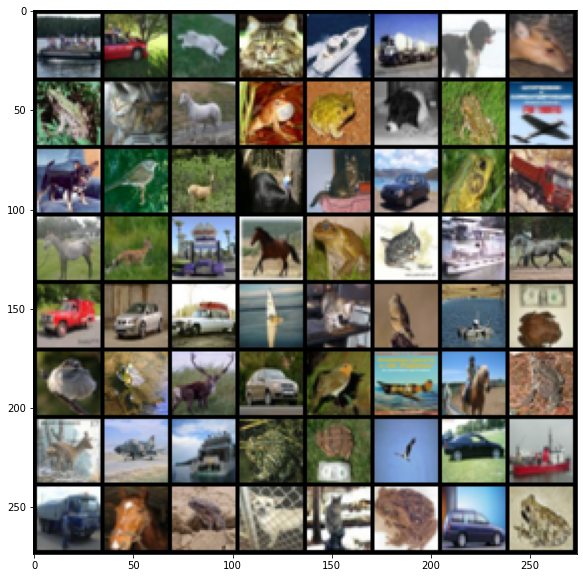

In [5]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))

## Part 1: Auto-Encoder
### Step one: Define 3 Models for Auto-Encoder
1. MLP-only model
2. CNN-MLP combination model
3. CNN-only model

In all the models, encoder and decoder should be consisting of $3$ layers each, and the encoder should be giving a flattened representation of size $32$.

Please see that each layer of encoder should decrease or keep equal the output size as compared to input size. Similarly, each layer of decoder should increase or keep equal the output size as compared to input size. 

In [6]:
class MLPAutoEncoder(nn.Module):
  def __init__(self):
    super(MLPAutoEncoder, self).__init__()
    
    self.encoder = nn.Sequential(
      nn.Linear(3072, 1024),
      nn.ReLU(),
      nn.Linear(1024, 256),
      nn.ReLU(),
      nn.Linear(256, 32), 
      nn.ReLU()
    )
    
    self.decoder = nn.Sequential(
      nn.Linear(32, 256),
      nn.ReLU(),
      nn.Linear(256, 1024),
      nn.ReLU(),
      nn.Linear(1024, 3072)
    )
  
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

class ComboAutoEncoder(nn.Module):
  def __init__(self):
    super(ComboAutoEncoder, self).__init__()
    
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 8, kernel_size=3, stride=1), # 8x30x30
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2), #8x15x15
      nn.Conv2d(8, 16, kernel_size=2, stride=1), #16x14x14
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),  #16x7x7
      nn.Conv2d(16, 32, kernel_size=3, stride=1), #32x5x5
      nn.ReLU(inplace=True)
    )
    
    # Decoder
    self.decoder = nn.Sequential(
      nn.Linear(32*5*5, 1200),
      nn.ReLU(inplace=True),
      nn.Linear(1200, 2200),
      nn.ReLU(inplace=True),
      nn.Linear(2200, 3*32*32),
      nn.Sigmoid()
    )
    
  def forward(self, x):
    x = self.encoder(x)
    x = x.view(x.size(0), -1)
    x = self.decoder(x)
    x = x.view(-1, 3, 32, 32)
    return x

class CNNAutoEncoder(nn.Module):
  def __init__(self):
    super(CNNAutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 8, kernel_size=4, stride=2), #15
      nn.ReLU(inplace=True),
      nn.Conv2d(8, 16, kernel_size=3, stride=2), #7
      nn.ReLU(inplace=True),
      nn.Conv2d(16, 32, kernel_size=3, stride=1), #5
      nn.ReLU(inplace=True)
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1), #7
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2), #15
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2), #32
      nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

### Step two: Using MSELoss, train all the models and analyse results
Make sure you also discuss size, time-taken and any other differences you found. Plot MSELoss for each epoch for all models. Also, tabulate the final MSELosses of all models and plot it vis-a-vis:

1. Model Size
2. Model Parameters
3. Time Taken per epoch 


USING Adam OPTIMISER and MLPAutoEncoder.



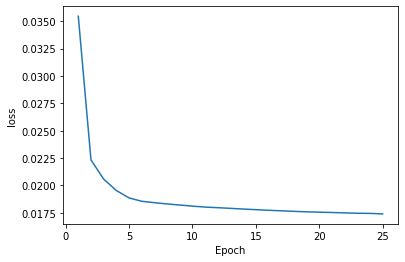

Final loss is 0.01740125865411118
Model Generated


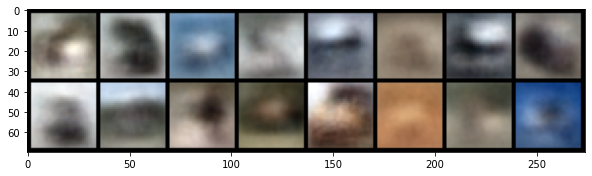

original


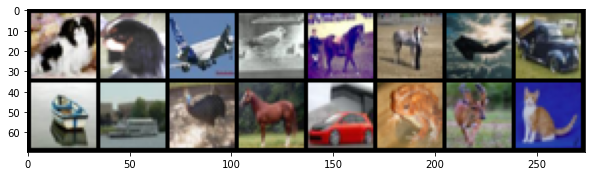

test Loss:  0.08667378514340729


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
epochs = 25
running_loss = []
val_loss = []
model1 = MLPAutoEncoder().to(device)
opt_name, optimiser = 'Adam', torch.optim.Adam(model1.parameters())
criterion = nn.MSELoss()
output =None
images =None
print(f'\nUSING {opt_name} OPTIMISER and MLPAutoEncoder.\n')
for epoch in range(epochs):
  train_loss = 0
  for batch, (images, labels) in enumerate(trainloader):
    # print(batch, images, labels)
    images = images.reshape(-1, 3*32*32).to(device)
    labels = labels.to(device)
    optimiser.zero_grad()
    output = model1(images)
    loss = criterion(output, images)
    loss.backward()
    optimiser.step()

    train_loss += loss.item()
    
  running_loss.append(train_loss/len(trainloader))
plt.plot(list(range(1, 26)), running_loss)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
print(f'Final loss is {running_loss[-1]}')
print('Model Generated')

imshow(torchvision.utils.make_grid(output.to('cpu').reshape(-1, 3, 32, 32)))
print("original")
imshow(torchvision.utils.make_grid(images.to('cpu').reshape(-1, 3, 32, 32)))
# Test the model: we don't need to compute gradients
with torch.no_grad():
  n_correct = 0
  n_samples = len(testloader.dataset)
  test_loss = 0
  for images, labels in testloader:
    images = images.reshape(-1, 3*32*32).to(device)

    outputs = model1(images)
    loss = criterion(outputs, images)
    test_loss += loss.item()

  print("test Loss: ", train_loss/len(testloader))
 



USING Adam OPTIMISER and ComboAutoEncoder.



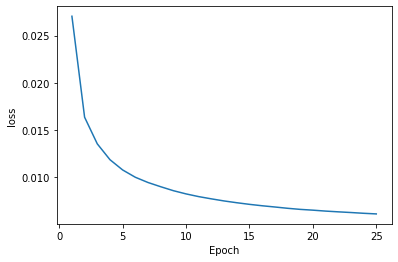

Final loss is 0.006080656139122898
Model Generated


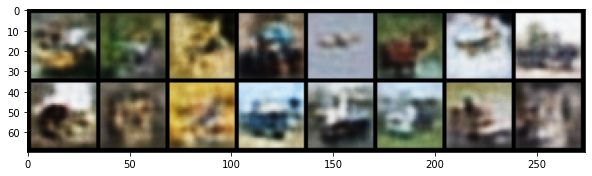

original


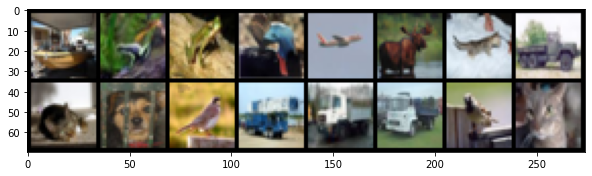

test Loss:  0.030287089813975203


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
epochs = 25
running_loss = []
val_loss = []
model2 = ComboAutoEncoder().to(device)
opt_name, optimiser = 'Adam', torch.optim.Adam(model2.parameters())
criterion = nn.MSELoss()
output =None
images =None
print(f'\nUSING {opt_name} OPTIMISER and ComboAutoEncoder.\n')
for epoch in range(epochs):
  train_loss = 0
  for batch, (images, labels) in enumerate(trainloader):
    # print(batch, images, labels)
    images = images.to(device)
    labels = labels.to(device)
    optimiser.zero_grad()
    output = model2(images)
    loss = criterion(output, images)
    loss.backward()
    optimiser.step()

    train_loss += loss.item()
    
  running_loss.append(train_loss/len(trainloader))
plt.plot(list(range(1, 26)), running_loss)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
print(f'Final loss is {running_loss[-1]}')
print('Model Generated')
imshow(torchvision.utils.make_grid(output.to('cpu')))
print("original")
imshow(torchvision.utils.make_grid(images.to('cpu')))
# Test the model: we don't need to compute gradients
with torch.no_grad():
  n_correct = 0
  n_samples = len(testloader.dataset)
  test_loss = 0
  for images, labels in testloader:
    images = images.to(device)

    outputs = model2(images)
    loss = criterion(outputs, images)
    test_loss += loss.item()

  print("test Loss: ",train_loss/len(testloader))
 



USING Adam OPTIMISER and CNNAutoEncoder.



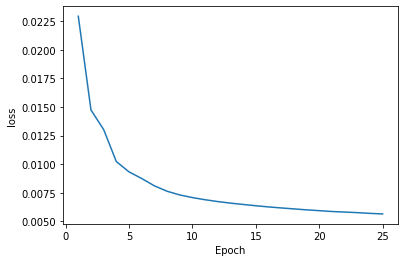

Final loss is 0.0056459546521487065
Model Generated


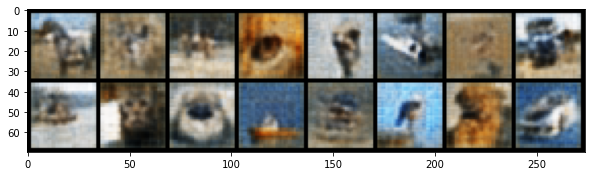

original


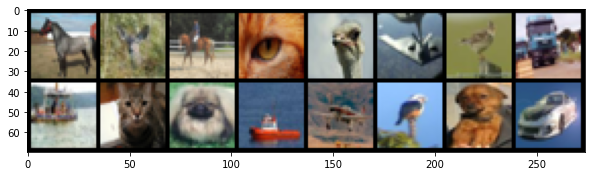

test Loss:  0.02812188877694451


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
epochs = 25
running_loss = []
val_loss = []
model3 = CNNAutoEncoder().to(device)
opt_name, optimiser = 'Adam', torch.optim.Adam(model3.parameters())
criterion = nn.MSELoss()
output =None
images =None
print(f'\nUSING {opt_name} OPTIMISER and CNNAutoEncoder.\n')
for epoch in range(epochs):
  train_loss = 0
  for batch, (images, labels) in enumerate(trainloader):
    # print(batch, images, labels)
    images = images.to(device)
    labels = labels.to(device)
    optimiser.zero_grad()
    output = model3(images)
    loss = criterion(output, images)
    loss.backward()
    optimiser.step()

    train_loss += loss.item()
    
  running_loss.append(train_loss/len(trainloader))
plt.plot(list(range(1, 26)), running_loss)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
print(f'Final loss is {running_loss[-1]}')
print('Model Generated')
imshow(torchvision.utils.make_grid(output.to('cpu')))
print("original")
imshow(torchvision.utils.make_grid(images.to('cpu')))
# Test the model: we don't need to compute gradients
with torch.no_grad():
  n_correct = 0
  n_samples = len(testloader.dataset)
  test_loss = 0
  for images, labels in testloader:
    images = images.to(device)

    outputs = model3(images)
    loss = criterion(outputs, images)
    test_loss += loss.item()

  print("test Loss: ",train_loss/len(testloader))
 


### Step three: Let's play with Representation Sizes
Spoilers: You must have found CNN to be more effective.

Have you ever wondered how varying the size of a CNN auto-encoder's representation can affect its performance? If so, here's a challenge for you: Implement a CNN auto-encoder with different representation sizes and observe the impact on the reconstruction quality.

Play with the following representation sizes:
1. 10
2. 32
3. 100
4. 1000

When working with different representation sizes in a CNN auto-encoder, we may reach a point of diminishing returns where increasing the representation size does not lead to significant improvements in reconstruction quality. This can be due to factors such as increased model complexity and longer training times. Discuss where you feel we might reach this point of diminishing returns when working with CIFAR-10 dataset and varying representation sizes.

Do analysis as suggested earlier.

In [12]:
# code and analysis here
class AutoEncoR10(nn.Module):
  def __init__(self):
    super(AutoEncoR10, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 8, kernel_size=4, stride=2), #15
      nn.ReLU(inplace=True),
      nn.Conv2d(8, 8, kernel_size=3, stride=2), #7
      nn.ReLU(inplace=True),
      nn.Conv2d(8, 10, kernel_size=3, stride=1), #5
      nn.ReLU(inplace=True)
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(10, 8, kernel_size=3, stride=1), #7
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2), #15
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2), #32
      nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [13]:
# code and analysis here
class AutoEncoR32(nn.Module):
  def __init__(self):
    super(AutoEncoR32, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 8, kernel_size=4, stride=2), #15
      nn.ReLU(inplace=True),
      nn.Conv2d(8, 16, kernel_size=3, stride=2), #7
      nn.ReLU(inplace=True),
      nn.Conv2d(16, 32, kernel_size=3, stride=1), #5
      nn.ReLU(inplace=True)
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1), #7
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2), #15
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2), #32
      nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [14]:
# code and analysis here
class AutoEncoR100(nn.Module):
  def __init__(self):
    super(AutoEncoR100, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 16, kernel_size=4, stride=2), #15
      nn.ReLU(inplace=True),
      nn.Conv2d(16, 48, kernel_size=3, stride=2), #7
      nn.ReLU(inplace=True),
      nn.Conv2d(48, 100, kernel_size=3, stride=1), #5
      nn.ReLU(inplace=True)
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(100, 48, kernel_size=3, stride=1), #7
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(48, 16, kernel_size=3, stride=2), #15
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2), #32
      nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [15]:
# code and analysis here
class AutoEncoR1000(nn.Module):
  def __init__(self):
    super(AutoEncoR1000, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=4, stride=2), #15
      nn.ReLU(inplace=True),
      nn.Conv2d(64, 256, kernel_size=3, stride=2), #7
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 1000, kernel_size=3, stride=1), #5
      nn.ReLU(inplace=True)
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(1000, 256, kernel_size=3, stride=1), #7
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2), #15
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2), #32
      nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


USING Adam OPTIMISER and 3 CNN Layers in Encoder and Decoder.



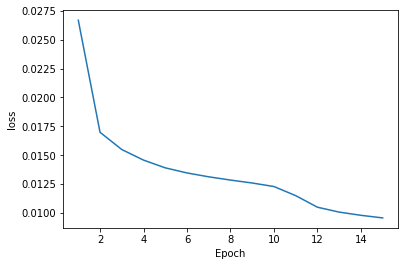

Final loss is 0.009569570703236649
Model Generated


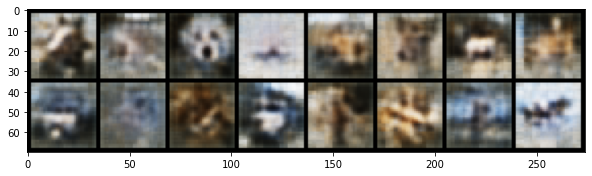

original


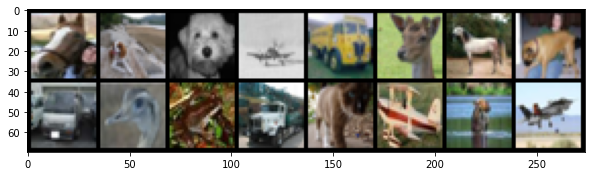

test Loss:  0.047664995477267894


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
epochs = 15
running_loss = []
val_loss = []
model_enco_10 = AutoEncoR10().to(device)
opt_name, optimiser = 'Adam', torch.optim.Adam(model_enco_10.parameters())
criterion = nn.MSELoss()
output =None
images =None
print(f'\nUSING {opt_name} OPTIMISER and 3 CNN Layers in Encoder and Decoder.\n')
for epoch in range(epochs):
  train_loss = 0
  for batch, (images, labels) in enumerate(trainloader):
    # print(batch, images, labels)
    images = images.to(device)
    labels = labels.to(device)
    optimiser.zero_grad()
    output = model_enco_10(images)
    loss = criterion(output, images)
    loss.backward()
    optimiser.step()

    train_loss += loss.item()
    
  running_loss.append(train_loss/len(trainloader))
plt.plot(list(range(1, 16)), running_loss)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
print(f'Final loss is {running_loss[-1]}')
print('Model Generated')
imshow(torchvision.utils.make_grid(output.to('cpu')))
print("original")
imshow(torchvision.utils.make_grid(images.to('cpu')))
# Test the model: we don't need to compute gradients
with torch.no_grad():
  n_correct = 0
  n_samples = len(testloader.dataset)
  test_loss = 0
  for images, labels in testloader:
    images = images.to(device)

    outputs = model_enco_10(images)
    loss = criterion(outputs, images)
    test_loss += loss.item()

  print("test Loss: ",train_loss/len(testloader))
 



USING Adam OPTIMISER and 3 CNN Layers in Encoder and Decoder.



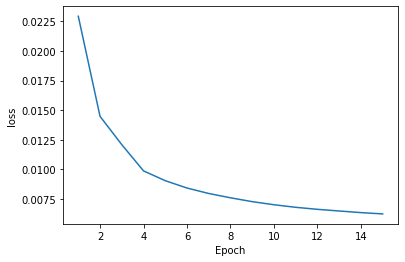

Final loss is 0.006244030276127636
Model Generated


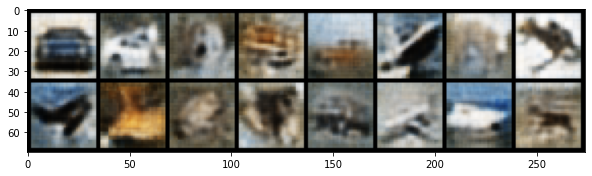

original


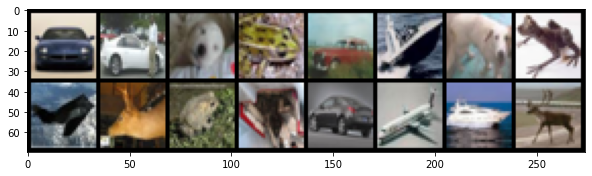

test Loss:  0.03110083870020262


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
epochs = 15
running_loss = []
val_loss = []
model = AutoEncoR32().to(device)
opt_name, optimiser = 'Adam', torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
output =None
images =None
print(f'\nUSING {opt_name} OPTIMISER and 3 CNN Layers in Encoder and Decoder.\n')
for epoch in range(epochs):
  train_loss = 0
  for batch, (images, labels) in enumerate(trainloader):
    # print(batch, images, labels)
    images = images.to(device)
    labels = labels.to(device)
    optimiser.zero_grad()
    output = model(images)
    loss = criterion(output, images)
    loss.backward()
    optimiser.step()

    train_loss += loss.item()
    
  running_loss.append(train_loss/len(trainloader))
plt.plot(list(range(1, 16)), running_loss)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
print(f'Final loss is {running_loss[-1]}')
print('Model Generated')
imshow(torchvision.utils.make_grid(output.to('cpu')))
print("original")
imshow(torchvision.utils.make_grid(images.to('cpu')))
# Test the model: we don't need to compute gradients
with torch.no_grad():
  n_correct = 0
  n_samples = len(testloader.dataset)
  test_loss = 0
  for images, labels in testloader:
    images = images.to(device)

    outputs = model(images)
    loss = criterion(outputs, images)
    test_loss += loss.item()

  print("test Loss: ",train_loss/len(testloader))
 



USING Adam OPTIMISER and 3 CNN Layers in Encoder and Decoder.



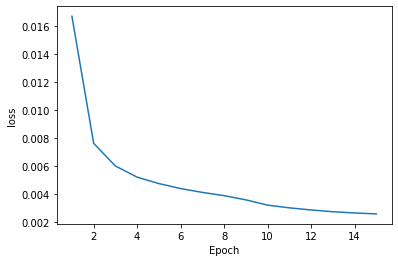

Final loss is 0.0026007770781602967
Model Generated


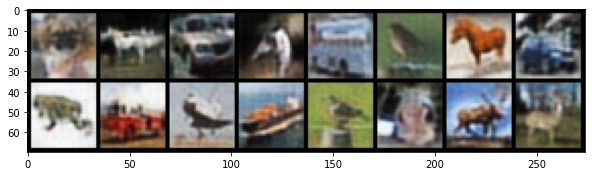

original


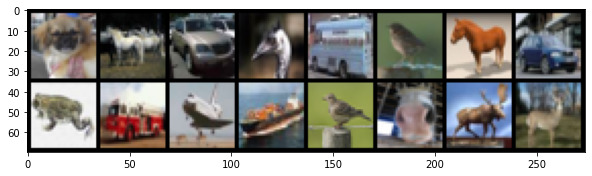

test Loss:  0.012954189013511797


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
epochs = 15
running_loss = []
val_loss = []
model = AutoEncoR100().to(device)
opt_name, optimiser = 'Adam', torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
output =None
images =None
print(f'\nUSING {opt_name} OPTIMISER and 3 CNN Layers in Encoder and Decoder.\n')
for epoch in range(epochs):
  train_loss = 0
  for batch, (images, labels) in enumerate(trainloader):
    # print(batch, images, labels)
    images = images.to(device)
    labels = labels.to(device)
    optimiser.zero_grad()
    output = model(images)
    loss = criterion(output, images)
    loss.backward()
    optimiser.step()

    train_loss += loss.item()
    
  running_loss.append(train_loss/len(trainloader))
plt.plot(list(range(1, 16)), running_loss)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
print(f'Final loss is {running_loss[-1]}')
print('Model Generated')
imshow(torchvision.utils.make_grid(output.to('cpu')))
print("original")
imshow(torchvision.utils.make_grid(images.to('cpu')))
# Test the model: we don't need to compute gradients
with torch.no_grad():
  n_correct = 0
  n_samples = len(testloader.dataset)
  test_loss = 0
  for images, labels in testloader:
    images = images.to(device)

    outputs = model(images)
    loss = criterion(outputs, images)
    test_loss += loss.item()

  print("test Loss: ",train_loss/len(testloader))
 



USING Adam OPTIMISER and 3 CNN Layers in Encoder and Decoder.



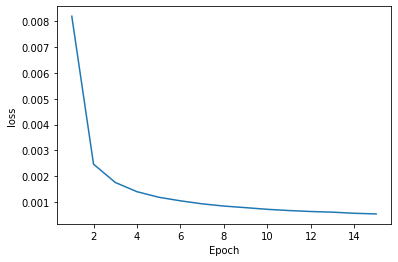

Final loss is 0.0005450680042983836
Model Generated


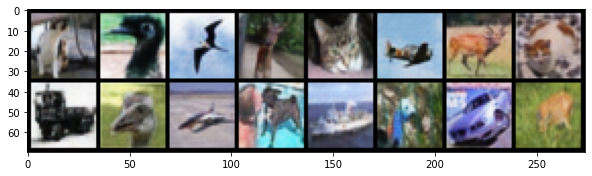

original


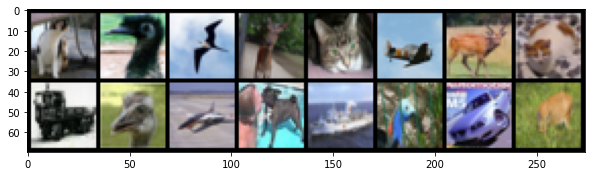

test Loss:  0.002714924709307872


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
epochs = 15
running_loss = []
val_loss = []
model = AutoEncoR1000().to(device)
opt_name, optimiser = 'Adam', torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
output =None
images =None
print(f'\nUSING {opt_name} OPTIMISER and 3 CNN Layers in Encoder and Decoder.\n')
for epoch in range(epochs):
  train_loss = 0
  for batch, (images, labels) in enumerate(trainloader):
    # print(batch, images, labels)
    images = images.to(device)
    labels = labels.to(device)
    optimiser.zero_grad()
    output = model(images)
    loss = criterion(output, images)
    loss.backward()
    optimiser.step()

    train_loss += loss.item()
    
  running_loss.append(train_loss/len(trainloader))
plt.plot(list(range(1, 16)), running_loss)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
print(f'Final loss is {running_loss[-1]}')
print('Model Generated')
imshow(torchvision.utils.make_grid(output.to('cpu')))
print("original")
imshow(torchvision.utils.make_grid(images.to('cpu')))
# Test the model: we don't need to compute gradients
with torch.no_grad():
  n_correct = 0
  n_samples = len(testloader.dataset)
  test_loss = 0
  for images, labels in testloader:
    images = images.to(device)

    outputs = model(images)
    loss = criterion(outputs, images)
    test_loss += loss.item()

  print("test Loss: ",train_loss/len(testloader))
 


### Step four: What about the number of layers?

Experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder can have a significant impact on its performance with CIFAR-10 dataset. For our next challenge, let's explore how the number of layers can affect the quality of the reconstructed images. Would a deeper or shallower network be more effective for this task?

Play with the following numbers of layers for encoder and decoder each:
1. 1
2. 3
3. 5
4. 10

When experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder, we may reach a point of diminishing returns where adding more layers does not result in significant improvements in reconstruction quality. Additionally, deeper networks may be prone to overfitting, especially when training data is limited. Discuss where you feel we reach it. 

Do analysis as suggested earlier.

In [20]:
# code and analysis here
class AutoEnco1(nn.Module):
  def __init__(self):
    super(AutoEnco1, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 256, kernel_size=12, stride=5), #5
        nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 3, kernel_size=12, stride=5), #32
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [21]:
# code and analysis here
class AutoEnco3(nn.Module):
  def __init__(self):
    super(AutoEnco3, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 16, kernel_size=4, stride=2), #15
      nn.ReLU(inplace=True),
      nn.Conv2d(16, 64, kernel_size=3, stride=2), #7
      nn.ReLU(inplace=True),
      nn.Conv2d(64, 256, kernel_size=3, stride=1), #5
      nn.ReLU(inplace=True)
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(256, 64, kernel_size=3, stride=1), #7
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(64, 16, kernel_size=3, stride=2), #15
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2), #32
      nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [22]:
class AutoEnco5(nn.Module):
  def __init__(self):
    super(AutoEnco5, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 16, kernel_size=4, stride=1),  # 29
      nn.ReLU(),
      nn.Conv2d(16, 32, kernel_size=5, stride=1),  # 25
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=5, stride=1),  # 21
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=3, stride=2),  # 10
      nn.ReLU(),
      nn.Conv2d(128, 256, kernel_size=2, stride=2),  # 5
      nn.ReLU()
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 10
      nn.ReLU(),
      nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),  # 21
      nn.ReLU(),
      nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1),  # 25
      nn.ReLU(),
      nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1),  # 29
      nn.ReLU(),
      nn.ConvTranspose2d(16, 3, kernel_size=4, stride=1),  # 32
      nn.Sigmoid()
    )
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [23]:
class AutoEnco10(nn.Module):
  def __init__(self):
    super(AutoEnco10, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 6, kernel_size=4, stride=1), #
      nn.ReLU(inplace=True),
      nn.Conv2d(6, 12, kernel_size=4, stride=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(12, 24, kernel_size=4, stride=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(24, 35, kernel_size=4, stride=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(35, 48, kernel_size=4, stride=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(48, 72, kernel_size=4, stride=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(72, 108, kernel_size=4, stride=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(108, 150, kernel_size=4, stride=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(150, 200, kernel_size=3, stride=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(200, 256, kernel_size=2, stride=1),
      nn.ReLU(inplace=True),
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(256, 200, kernel_size=2, stride=1),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(200, 150, kernel_size=3, stride=1),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(150, 108, kernel_size=4, stride=1),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(108, 72, kernel_size=4, stride=1),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(72, 48, kernel_size=4, stride=1),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(48, 35, kernel_size=4, stride=1),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(35, 24, kernel_size=4, stride=1),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(24, 12, kernel_size=4, stride=1), 
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(12, 6, kernel_size=4, stride=1), 
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(6, 3, kernel_size=4, stride=1), 
      nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


USING Adam OPTIMISER and 1 CNN Layer in Encoder and Decoder.



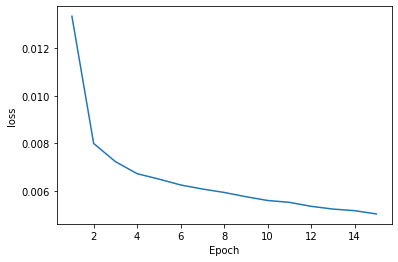

Final loss is 0.005022057374972669
Model Generated


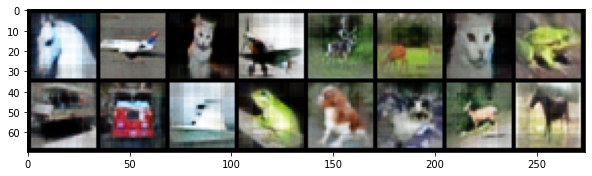

original


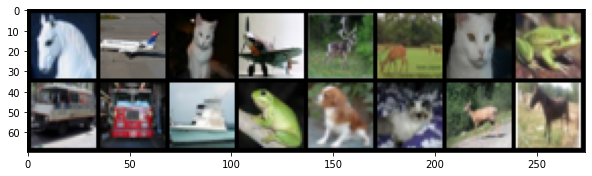

test Loss:  0.0250143239950868


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
epochs = 15
running_loss = []
val_loss = []
model = AutoEnco1().to(device)
opt_name, optimiser = 'Adam', torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
output =None
images =None
print(f'\nUSING {opt_name} OPTIMISER and 1 CNN Layer in Encoder and Decoder.\n')
for epoch in range(epochs):
  train_loss = 0
  for batch, (images, labels) in enumerate(trainloader):
    # print(batch, images, labels)
    images = images.to(device)
    labels = labels.to(device)
    optimiser.zero_grad()
    output = model(images)
    loss = criterion(output, images)
    loss.backward()
    optimiser.step()

    train_loss += loss.item()
    
  running_loss.append(train_loss/len(trainloader))
plt.plot(list(range(1, 16)), running_loss)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
print(f'Final loss is {running_loss[-1]}')
print('Model Generated')
imshow(torchvision.utils.make_grid(output.to('cpu')))
print("original")
imshow(torchvision.utils.make_grid(images.to('cpu')))
# Test the model: we don't need to compute gradients
with torch.no_grad():
  n_correct = 0
  n_samples = len(testloader.dataset)
  test_loss = 0
  for images, labels in testloader:
    images = images.to(device)

    outputs = model(images)
    loss = criterion(outputs, images)
    test_loss += loss.item()

  print("test Loss: ",train_loss/len(testloader))


USING Adam OPTIMISER and 3 CNN Layers in Encoder and Decoder.



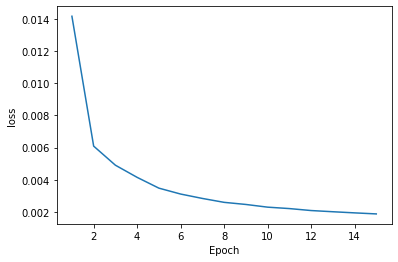

Final loss is 0.001881616017685922
Model Generated


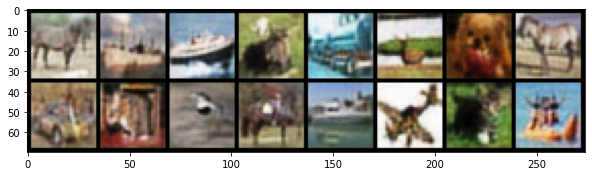

original


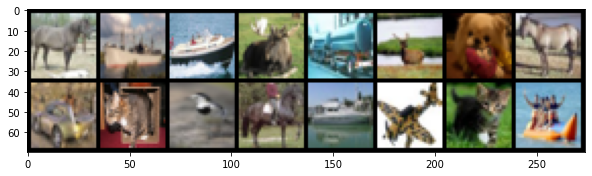

test Loss:  0.00937212564223179


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
epochs = 15
running_loss = []
val_loss = []
model = AutoEnco3().to(device)
opt_name, optimiser = 'Adam', torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
output =None
images =None
print(f'\nUSING {opt_name} OPTIMISER and 3 CNN Layers in Encoder and Decoder.\n')
for epoch in range(epochs):
  train_loss = 0
  for batch, (images, labels) in enumerate(trainloader):
    # print(batch, images, labels)
    images = images.to(device)
    labels = labels.to(device)
    optimiser.zero_grad()
    output = model(images)
    loss = criterion(output, images)
    loss.backward()
    optimiser.step()

    train_loss += loss.item()
    
  running_loss.append(train_loss/len(trainloader))
plt.plot(list(range(1, 16)), running_loss)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
print(f'Final loss is {running_loss[-1]}')
print('Model Generated')
imshow(torchvision.utils.make_grid(output.to('cpu')))
print("original")
imshow(torchvision.utils.make_grid(images.to('cpu')))
# Test the model: we don't need to compute gradients
with torch.no_grad():
  n_correct = 0
  n_samples = len(testloader.dataset)
  test_loss = 0
  for images, labels in testloader:
    images = images.to(device)

    outputs = model(images)
    loss = criterion(outputs, images)
    test_loss += loss.item()

  print("test Loss: ",train_loss/len(testloader))
 



USING Adam OPTIMISER and 5 CNN Layers in Encoder and Decoder.



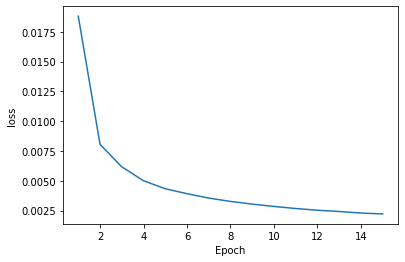

Final loss is 0.0022190654296916253
Model Generated


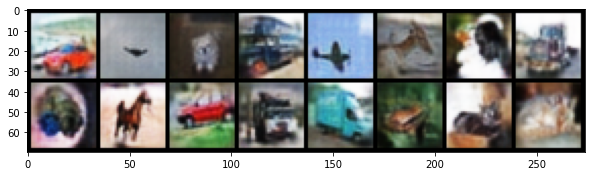

original


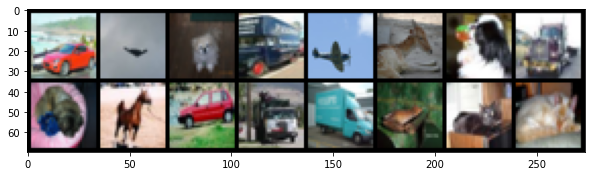

test Loss:  0.011052924624323892


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
epochs = 15
running_loss = []
val_loss = []
model = AutoEnco5().to(device)
opt_name, optimiser = 'Adam', torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
output =None
images =None
print(f'\nUSING {opt_name} OPTIMISER and 5 CNN Layers in Encoder and Decoder.\n')
for epoch in range(epochs):
  train_loss = 0
  for batch, (images, labels) in enumerate(trainloader):
    # print(batch, images, labels)
    images = images.to(device)
    labels = labels.to(device)
    optimiser.zero_grad()
    output = model(images)
    loss = criterion(output, images)
    loss.backward()
    optimiser.step()

    train_loss += loss.item()
    
  running_loss.append(train_loss/len(trainloader))
plt.plot(list(range(1, epochs+1)), running_loss)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
print(f'Final loss is {running_loss[-1]}')
print('Model Generated')
imshow(torchvision.utils.make_grid(output.to('cpu')))
print("original")
imshow(torchvision.utils.make_grid(images.to('cpu')))
# Test the model: we don't need to compute gradients
with torch.no_grad():
  n_correct = 0
  n_samples = len(testloader.dataset)
  test_loss = 0
  for images, labels in testloader:
    images = images.to(device)

    outputs = model(images)
    loss = criterion(outputs, images)
    test_loss += loss.item()

  print("test Loss: ",train_loss/len(testloader))
 



USING Adam OPTIMISER and 10 CNN Layers in Encoder and Decoder.



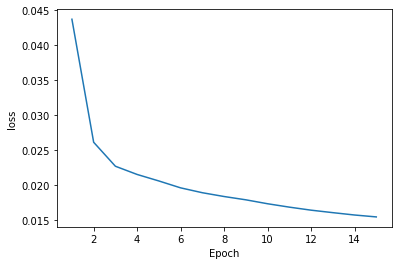

Final loss is 0.015480727626634834
Model Generated


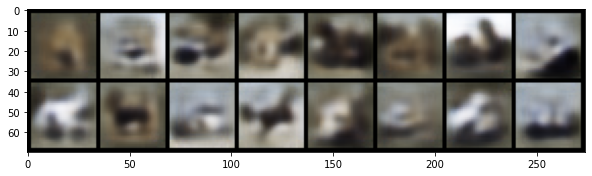

original


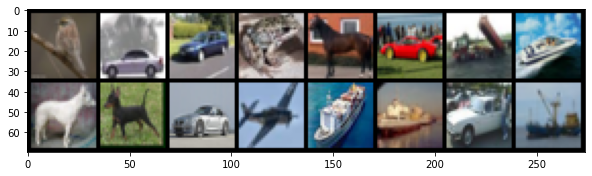

test Loss:  0.07710782805113656


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
epochs = 15
running_loss = []
val_loss = []
model = AutoEnco10().to(device)
opt_name, optimiser = 'Adam', torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
output =None
images =None
print(f'\nUSING {opt_name} OPTIMISER and 10 CNN Layers in Encoder and Decoder.\n')
for epoch in range(epochs):
  train_loss = 0
  for batch, (images, labels) in enumerate(trainloader):
    # print(batch, images, labels)
    images = images.to(device)
    labels = labels.to(device)
    optimiser.zero_grad()
    output = model(images)
    loss = criterion(output, images)
    loss.backward()
    optimiser.step()

    train_loss += loss.item()
    
  running_loss.append(train_loss/len(trainloader))
plt.plot(list(range(1, 16)), running_loss)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
print(f'Final loss is {running_loss[-1]}')
print('Model Generated')
imshow(torchvision.utils.make_grid(output.to('cpu')))
print("original")
imshow(torchvision.utils.make_grid(images.to('cpu')))
# Test the model: we don't need to compute gradients
with torch.no_grad():
  n_correct = 0
  n_samples = len(testloader.dataset)
  test_loss = 0
  for images, labels in testloader:
    images = images.to(device)

    outputs = model(images)
    loss = criterion(outputs, images)
    test_loss += loss.item()

  print("test Loss: ",train_loss/len(testloader))
 


### Explaination time!
Please write a short-essay explaining what AutoEncoder does, how it is different from other data-representation methods like PCA, t-SNE and Variational AutoEncoders. Also tell what were your take-outs from this experiment.

In [ ]:
# explainations here
"""
AutoEncoders are a type of neural network which consists of two parts, an encoder and a decoder.
The encoder takes the input and reduces the dimension of the input while preserving
as much important information as possible. The decoder part takes the reduced form of the input 
which is produced by the encoder and then tries to reconstruct the original input from the reduced form.
As we want our end result produced by the decoder to be as close to the original input as possible.
The loss is computed with respect to the input itself, as we don't need any explicit labels in this method
and the input is reused to compute the loss, it is neither supervised nor completely unsupervised.
but we call it to be self supervised.

like auto encoders PCA can also be used for dimensionality reduction.
In PCA we find the most important components of the input data by maximizing the variance.
this is a linear method for reducing the dimensionality of data and wont be able to capture
nonlinear or complex relationships in the data or variables whereas neural network based autoencoder
works much better in this scenario.

t-SNE is mostly used for visualization and not data pre-processing technique. 
it is used to visualize high dimension data into low dimension typically 2D or 3D,
it preserves the the similarity and relative positions between points in higher dimension into lower dimensions

Variational AutoEncoders(VAEs) similar to autoencoders but with additional components.
VAEs have an additional probabilistic layer that is not present in autoencoders, that models the distribution of the latent space.
The probabilistic layer in VAEs allows the network to learn a more meaningful and continuous representation of the input data.
Rather than mapping each input to a specific point in the latent space, 
VAEs map each input to a probability distribution over the latent space. This means that the VAE can generate new samples
by sampling from the learned probability distribution. VAE can be used for tasks like data generation, interpolation, and manipulation.

Autoencoders can be used to learn a compressed representation of input data. By training an autoencoder to compress the input
data into a lower-dimensional space, we can learn a representation of the data that captures the most important features and
patterns. This can be useful for tasks such as data compression, anomaly detection, image denoising, and dimensionality reduction.
CNNs are specifically designed for processing data that has a grid-like structure, such as images, videos. 
CNNs learn to automatically extract features from the input data by applying a series of filters that capture different patterns in the data.
These filters are learned through the backpropagation algorithm during training, and they are able to capture both low-level features like 
edges and textures, as well as high-level features like shapes and objects. CNNs have been used for a wide range of tasks such as image classification, 
object detection, facial recognition, and natural language processing.
"""

## Part 2: The return of kNN
Autoencoder representations can be useful for a wide range of machine learning tasks beyond just reconstructing input data. For example, the output of an encoder can be used as a feature representation for classification using k-Nearest Neighbors (kNN) or other classifiers. Similarly, the encoded representations can be used for unsupervised tasks like clustering, where the model groups similar images together based on their feature representation. This makes autoencoders a versatile tool for feature learning, with the potential to enhance the performance of a wide range of machine learning algorithms.

Since we have already trained auto-encoder on CIFAR-10, we will employ the encoder from the CNN model with representation size of $10$. Using a subset of CIFAR-10 train and test datasets, each with 10,000 and 1000 samples respectively, with an equal number of samples for each class, implement kNN classification using the encoder output as features. Share your findings and accuracy, F1 score and other relavant metrics on the test set. What insights can you draw from the results?

You are allowed to use sklearn or any other library for kNN and splitting dataset.

In [30]:
# code and analysis here. Remember to keep your analysis of high quality at all times.
from torch.utils.data import DataLoader, Subset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1
                                                    , shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1
                                                    , shuffle=True, num_workers=2)
train_subset = np.random.randint(0, 50000, 10000)
test_subset = np.random.randint(0, 10000, 1000)
train_subset = Subset(trainloader.dataset, train_subset)
test_subset = Subset(testloader.dataset, test_subset)

# create a new DataLoader instance for the subset
trainloader = DataLoader(train_subset, batch_size=1, shuffle=True)
testloader = DataLoader(test_subset, batch_size=1, shuffle=True)


In [31]:
X_test = []
X_train = []
y_test = []
y_train = []
with torch.no_grad():
  for images, labels in testloader:
    images = images.to(device)
    outputs = model_enco_10(images)
    X_test.append(outputs.to('cpu').numpy().flatten())
    y_test.append(labels.item())
  for images, labels in trainloader:
    images = images.to(device)
    outputs = model_enco_10(images)
    X_train.append(outputs.to('cpu').numpy().flatten())
    y_train.append(labels.item())
X_test = np.asarray(X_test)
X_train = np.asarray(X_train)
y_test = np.asarray(y_test)
y_train = np.asarray(y_train)

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
acc = accuracy_score(pred, y_test)
print(f'{acc*100:.2f}')

31.90


## Part 3: Siamese Network (not part of assignment)
Siamese networks are useful for comparing and finding similarities between two inputs. The inputs from identical encoder sub-networks will be given as an input to a dense network (an MLP) and the prediction will be given as output of a Sigmoid function.

Employ the encoder from the best model to be used as the two-identical sub-networks of the Siamese Network. So, copy the weights from the best encoder to the two-identical sub-networks, set the learning rate of this encoder to be lower by a couple of order than that of the dense network.

Who knows, this might be part of next assignment during hectic times. (wink wink)
(Don't quote me on this though)

### Step one: Define a Siamese Network

In [ ]:
# sample.
class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder1 = encoder
        self.encoder2 = encoder
        self.decoder = nn.Sequential(
            nn.Linear(2048,1024),
            # whatever
        )

    def forward(self, x1, x2):
        encoded1 = self.encoder1(x1)
        encoded2 = self.encoder2(x2)
        return (encoded1,encoded2)
        
    def differentiate(self, x1_embedding, x2_embedding):
        x = torch.cat([x1_embedding,x2_embedding],dim=1)
        return self.decoder(x)


### Step two: Define the following three losses:
1. TripletLoss
2. ContrastiveLoss
3. Regularized Cross Entropy Loss

In [ ]:
# TripletLoss defined as an example
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute the distances between the anchor, positive, and negative examples
        distance_pos = F.pairwise_distance(anchor, positive, p=2)
        distance_neg = F.pairwise_distance(anchor, negative, p=2)
        # Compute the triplet loss using the margin
        loss_triplet = torch.mean(torch.clamp(distance_pos - distance_neg + self.margin, min=0.0))
        return loss_triplet

In [ ]:
# code here

### Train the Siamese network...
... and write a function that takes 2 inputs and outputs whether they belong to the same class or not. Plot and share the results of the function. The results should contain both successful results, i.e. classification as 'same' for inputs belonging to the same class and classification as 'not-same' for inputs belonging to different classes, as well as some unsuccessful results (that gives the wrong output than expected).
Provide an explanation of why the unsuccessful results might occur.

In [ ]:
# code and analysis here

### And again. What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

To re-iterate: "Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations."